In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [100]:
import zipfile
with zipfile.ZipFile('./Image_classification_data.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

In [101]:
#Loading Main Data
data = pd.read_csv('data_labels_mainData.csv')
print(data.head())

   InstanceID  patientID  ImageName cellTypeName  cellType  isCancerous
0       22405          1  22405.png   fibroblast         0            0
1       22406          1  22406.png   fibroblast         0            0
2       22407          1  22407.png   fibroblast         0            0
3       22408          1  22408.png   fibroblast         0            0
4       22409          1  22409.png   fibroblast         0            0


In [102]:
#Checking for Nulls
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9896 entries, 0 to 9895
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   InstanceID    9896 non-null   int64 
 1   patientID     9896 non-null   int64 
 2   ImageName     9896 non-null   object
 3   cellTypeName  9896 non-null   object
 4   cellType      9896 non-null   int64 
 5   isCancerous   9896 non-null   int64 
dtypes: int64(4), object(2)
memory usage: 464.0+ KB


**There are no null values in the data**

## EDA

In [6]:
#Check frequency of Categorical features to ensure that there are no errors 
frequency_name = data.groupby('cellTypeName').apply(len)
frequency_int = data.groupby('cellType').apply(len)

print(frequency_name)
print("----")
print(frequency_int)

cellTypeName
epithelial      4079
fibroblast      1888
inflammatory    2543
others          1386
dtype: int64
----
cellType
0    1888
1    2543
2    4079
3    1386
dtype: int64


We can observe that there are no error values in both categorical features and the distribution is equal among both features

isCancerous
0    5817
1    4079
Name: count, dtype: int64


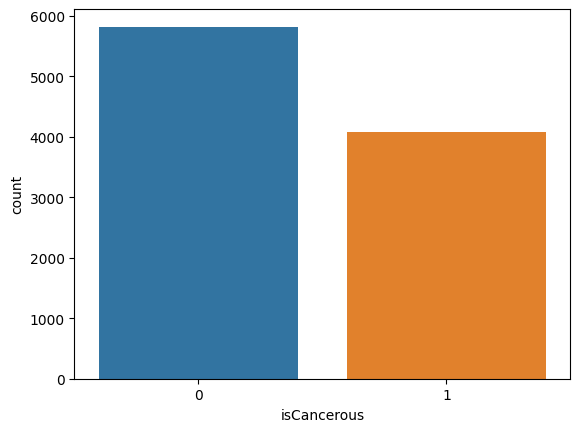

In [7]:
print(data['isCancerous'].value_counts())
sns.countplot(x='isCancerous', data=data)
plt.show()

**We have more instances of non-cancerous images**
**Further exploration is required to confirm any correlations**

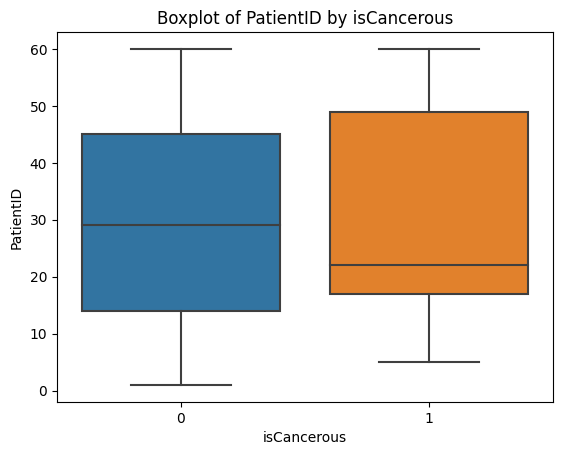

In [8]:
# Boxplots to observe relationship between PatientId and isCancerous
sns.boxplot(x='isCancerous', y='patientID', data=data)
plt.title('Boxplot of PatientID by isCancerous')
plt.xlabel('isCancerous')
plt.ylabel('PatientID')
plt.show()

**No apparent correlation can be found**

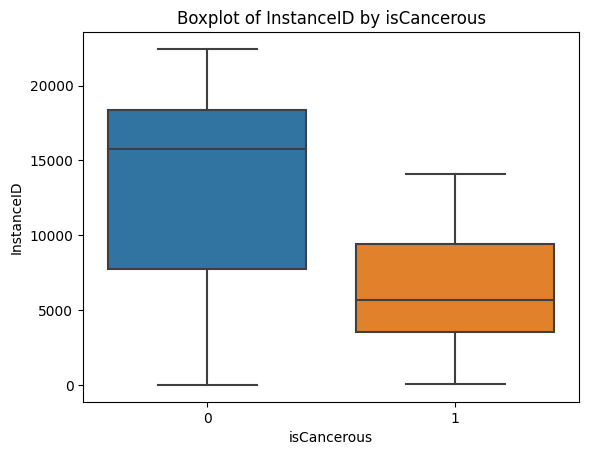

In [9]:
# Plot boxplots of numeric variables
sns.boxplot(x='isCancerous', y='InstanceID', data=data)
plt.title('Boxplot of InstanceID by isCancerous')
plt.xlabel('isCancerous')
plt.ylabel('InstanceID')
plt.show()

**We can see that the initial instanceIDs had much more occurances of cancerous cells rather than the later instances**

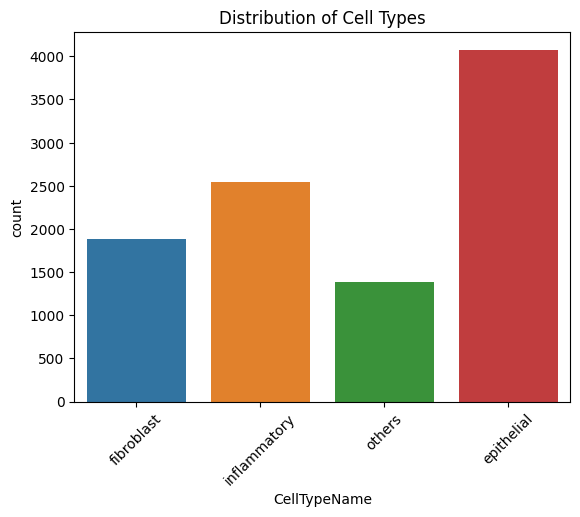

In [10]:
# Check distribution of cell types
sns.countplot(x='cellTypeName', data=data)
plt.title('Distribution of Cell Types')
plt.xlabel('CellTypeName')
plt.xticks(rotation=45)
plt.show()

**We have a notably higher number of epithelial cells as compared to other types of cells**

ValueError: could not convert string to float: '22405.png'

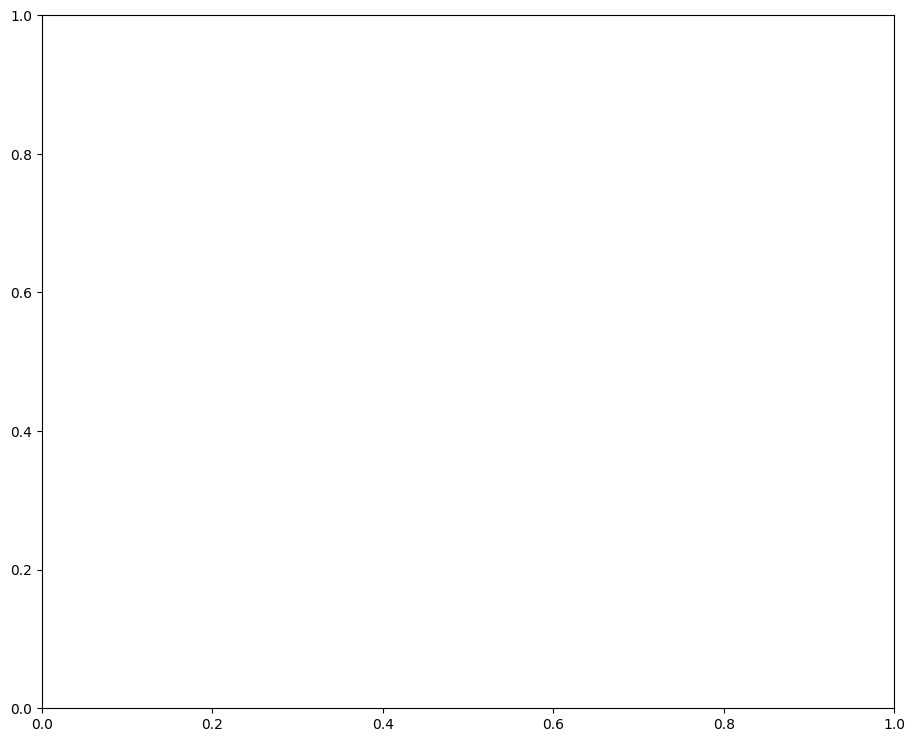

In [11]:
f, ax = plt.subplots(figsize=(11, 9))
corr = data.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    annot=True
)

**Observations**
- As observed with boxplots, a correlation exists between the instance and isCancerous target value
- There is also a correlation between the two target variables: cellType and isCancerous. This can be explored further

In [12]:
from PIL import Image

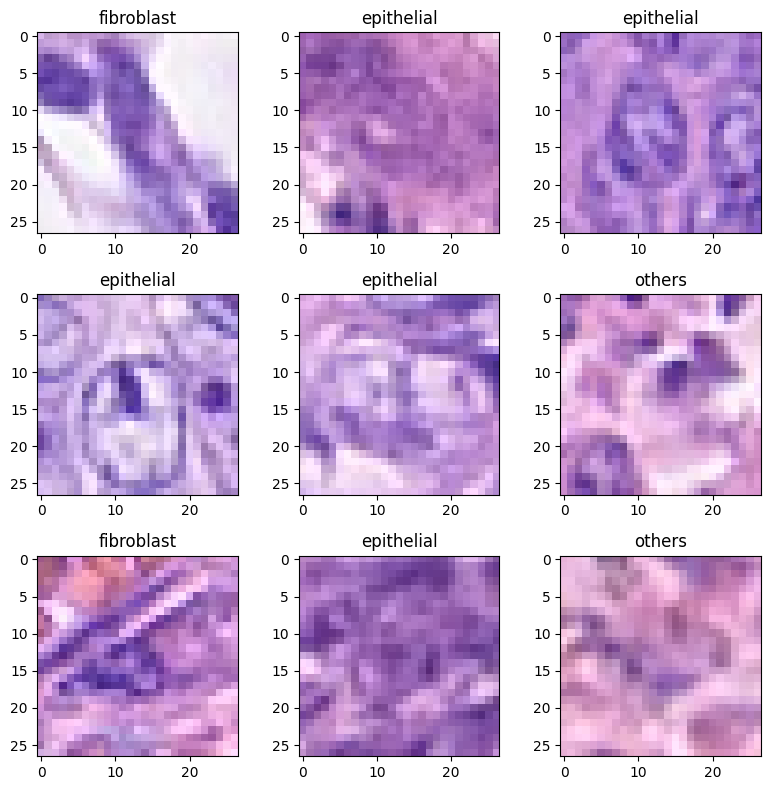

In [13]:
# Display sample images
sample_images = data['ImageName'].sample(9)
plt.figure(figsize=(8,8))
for i, img_name in enumerate(sample_images):
    plt.subplot(3,3,i+1)
    img = Image.open('patch_images/' + img_name)
    plt.imshow(img)
    plt.title(data[data['ImageName']==img_name]['cellTypeName'].values[0])
plt.tight_layout()
plt.show()

**Observations**
- While these are random samples, we can see a specific pattern of round purple objects in epithelical cells

In [14]:
# Check for image dimensions
img_dims = []
for img_name in data['ImageName']:
    img = Image.open('patch_images/' + img_name)
    img_dims.append(img.size)
img_dims = np.array(img_dims)
print('Image Dimensions:')
print('Min:', np.min(img_dims, axis=0))
print('Max:', np.max(img_dims, axis=0))
print('Mean:', np.mean(img_dims, axis=0))

Image Dimensions:
Min: [27 27]
Max: [27 27]
Mean: [27. 27.]


The images have a consistent size of 27x27 pixels

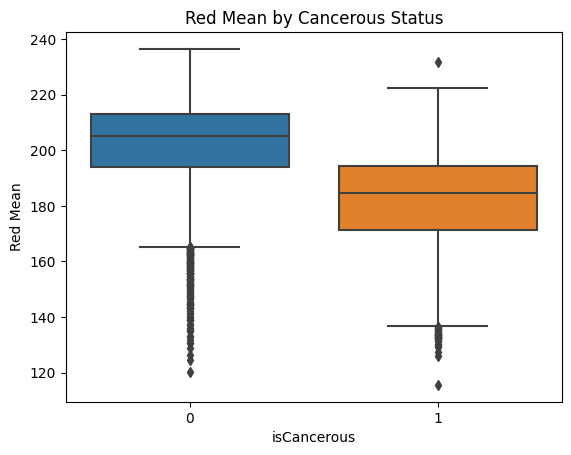

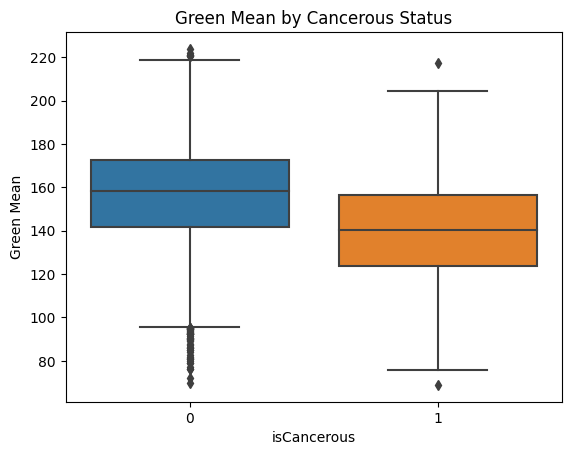

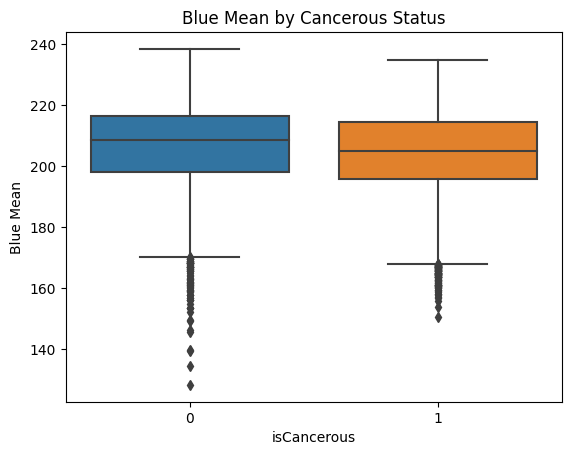

In [15]:
# Check for color distribution
colors = ['Red', 'Green', 'Blue']
for color in colors:
    color_values = []
    for img_name in data['ImageName']:
        img = Image.open('patch_images/' + img_name)
        color_values.append(np.mean(np.array(img)[:,:,colors.index(color)]))
    data[color + ' Mean'] = color_values
sns.boxplot(x='isCancerous', y='Red Mean', data=data)
plt.title('Red Mean by Cancerous Status')
plt.show()
sns.boxplot(x='isCancerous', y='Green Mean', data=data)
plt.title('Green Mean by Cancerous Status')
plt.show()
sns.boxplot(x='isCancerous', y='Blue Mean', data=data)
plt.title('Blue Mean by Cancerous Status')
plt.show()

**Observations**
- Non Cancerous cells have higher values of the color red
- Non Cancerous cells have higher values of the color Green
- Color of Blue is mostly evenly distributed among Cancerous and non cancerous images

In [16]:
# Check for edge cases
edge_cases = []
for img_name in data['ImageName']:
    img = Image.open('patch_images/' + img_name)
    if np.max(np.array(img)) > 255:
        edge_cases.append(img_name)
print('Number of edge cases:', len(edge_cases))

if(len(edge_cases)>=1):
    print('Example edge case:', edge_cases[0])
    img = Image.open('Image_classification_data/patch_images/' + edge_cases[0])
    plt.imshow(img)
    plt.title('Example Edge Case')
    plt.show()

Number of edge cases: 0


# Constructing a Baseline Model

In [156]:
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd

OUTPUT_CLASSES = 4

train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=42)

print("Train data : {}, Val data: {}, Test Data: {}".format(train_data.shape[0], val_data.shape[0],test_data.shape[0]))

Train data : 5937, Val data: 1979, Test Data: 1980


In [165]:
train_data['cellType'] = train_data['cellType'].astype('str')
val_data['cellType'] = val_data['cellType'].astype('str')

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator()
val_datagen = ImageDataGenerator()

batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./patch_images',
        x_col= "ImageName",
        y_col="cellType",
        target_size=(32, 32),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./patch_images',
        x_col= "ImageName",
        y_col="cellType",
        target_size=(32, 32),
        batch_size=batch_size,
        class_mode='categorical')

Found 5937 validated image filenames belonging to 4 classes.
Found 1979 validated image filenames belonging to 4 classes.


In [166]:
import matplotlib.pyplot as plt
def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, metric_name='Accuracy'):
    plt.figure(figsize=(10,5))
    
    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')

    plt.show()

In [167]:
import tensorflow as tf
from keras.optimizers import SGD

model_base = Sequential()
model_base.add(Dense(32, activation='relu', kernel_initializer='he_uniform', input_shape=(32, 32, 3)))
model_base.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
model_base.add(Flatten())
model_base.add(Dense(4, activation='relu'))

In [168]:
model_base.compile(optimizer=SGD(),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['categorical_accuracy'])

In [169]:
history = model_base.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=25,
    validation_data=validation_generator,
    validation_steps=len(validation_generator))

Epoch 1/25
186/186 [==============================] - 4s 22ms/step - loss: 13.0690 - categorical_accuracy: 0.1875 - val_loss: 13.0069 - val_categorical_accuracy: 0.1930
Epoch 2/25
186/186 [==============================] - 4s 20ms/step - loss: 13.0910 - categorical_accuracy: 0.1878 - val_loss: 13.0069 - val_categorical_accuracy: 0.1930
Epoch 3/25
186/186 [==============================] - 4s 20ms/step - loss: 13.0910 - categorical_accuracy: 0.1878 - val_loss: 13.0069 - val_categorical_accuracy: 0.1930
Epoch 4/25
186/186 [==============================] - 4s 20ms/step - loss: 13.0910 - categorical_accuracy: 0.1878 - val_loss: 13.0069 - val_categorical_accuracy: 0.1930
Epoch 5/25
171/186 [==========================>...] - ETA: 0s - loss: 13.0906 - categorical_accuracy: 0.1878

KeyboardInterrupt: 

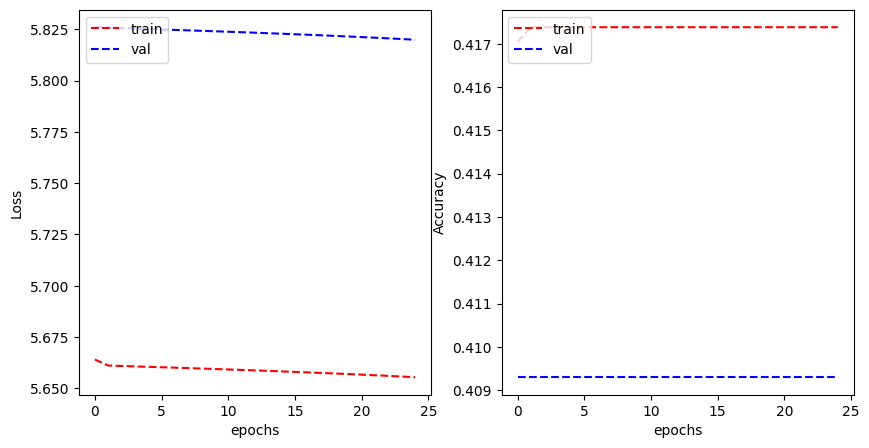

In [162]:
plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['categorical_accuracy'], history.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [170]:
train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last', rotation_range=45, width_shift_range=0.23,
                                   height_shift_range=0.23)
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./patch_images',
        x_col= "ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./patch_images',
        x_col= "ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 5937 validated image filenames belonging to 4 classes.
Found 1979 validated image filenames belonging to 4 classes.


In [171]:
import tensorflow as tf
from keras.optimizers import SGD
from keras import regularizers
from tensorflow.keras import layers

model = tf.keras.Sequential()
# Convolutional layers
model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(27, 27, 3)))
model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
          
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_uniform',))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_uniform',))
model.add(layers.MaxPooling2D((2, 2)))
          
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_uniform',))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_uniform',))
model.add(MaxPooling2D((2, 2)))

# Flatten layer
model.add(layers.Flatten())

# Dense layers
model.add(layers.Dense(512, activation='relu', kernel_initializer='he_uniform'))
model.add(layers.Dropout(rate=0.5))
model.add(layers.Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(layers.Dropout(rate=0.5))

# Output layer
model.add(layers.Dense(OUTPUT_CLASSES, activation='softmax'))


In [172]:
from keras.utils import to_categorical
from sklearn.utils import compute_class_weight
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.optimizers import SGD

class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(data['cellType']),
                                        y = data['cellType']                                                    
                                    )
class_weights = dict(zip(np.unique(data['cellType']), class_weights))

loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False)

model.compile(optimizer=Adam(),
              loss=loss,
              metrics=['categorical_accuracy', 'mse'])


learn_control = ReduceLROnPlateau(monitor='val_categorical_accuracy', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-20)

filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=1, save_best_only=True, mode='max')

In [173]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=60,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    class_weight=class_weights,
    shuffle=True,
    callbacks=[learn_control, checkpoint])

Epoch 1/60
186/186 [==============================] - ETA: 0s - loss: 1.3261 - categorical_accuracy: 0.3812 - mse: 0.1756
Epoch 1: val_categorical_accuracy improved from -inf to 0.47852, saving model to weights.best.hdf5
186/186 [==============================] - 7s 34ms/step - loss: 1.3261 - categorical_accuracy: 0.3812 - mse: 0.1756 - val_loss: 1.1569 - val_categorical_accuracy: 0.4785 - val_mse: 0.1562 - lr: 0.0010
Epoch 2/60
186/186 [==============================] - ETA: 0s - loss: 1.0845 - categorical_accuracy: 0.5782 - mse: 0.1348
Epoch 2: val_categorical_accuracy improved from 0.47852 to 0.68317, saving model to weights.best.hdf5
186/186 [==============================] - 5s 28ms/step - loss: 1.0845 - categorical_accuracy: 0.5782 - mse: 0.1348 - val_loss: 0.8197 - val_categorical_accuracy: 0.6832 - val_mse: 0.1112 - lr: 0.0010
Epoch 3/60
184/186 [============================>.] - ETA: 0s - loss: 0.9752 - categorical_accuracy: 0.6446 - mse: 0.1201
Epoch 3: val_categorical_accura

185/186 [============================>.] - ETA: 0s - loss: 0.6945 - categorical_accuracy: 0.7585 - mse: 0.0859
Epoch 21: val_categorical_accuracy improved from 0.78929 to 0.79838, saving model to weights.best.hdf5
186/186 [==============================] - 5s 28ms/step - loss: 0.6944 - categorical_accuracy: 0.7585 - mse: 0.0859 - val_loss: 0.5488 - val_categorical_accuracy: 0.7984 - val_mse: 0.0734 - lr: 0.0010
Epoch 22/60
184/186 [============================>.] - ETA: 0s - loss: 0.6865 - categorical_accuracy: 0.7652 - mse: 0.0838
Epoch 22: val_categorical_accuracy did not improve from 0.79838
186/186 [==============================] - 5s 27ms/step - loss: 0.6891 - categorical_accuracy: 0.7642 - mse: 0.0841 - val_loss: 0.6758 - val_categorical_accuracy: 0.7398 - val_mse: 0.0915 - lr: 0.0010
Epoch 23/60
184/186 [============================>.] - ETA: 0s - loss: 0.6876 - categorical_accuracy: 0.7635 - mse: 0.0836
Epoch 23: val_categorical_accuracy did not improve from 0.79838
186/186 [=

186/186 [==============================] - ETA: 0s - loss: 0.5200 - categorical_accuracy: 0.8268 - mse: 0.0625
Epoch 41: val_categorical_accuracy did not improve from 0.81304
186/186 [==============================] - 5s 27ms/step - loss: 0.5200 - categorical_accuracy: 0.8268 - mse: 0.0625 - val_loss: 0.5087 - val_categorical_accuracy: 0.8110 - val_mse: 0.0682 - lr: 4.0000e-05
Epoch 42/60
184/186 [============================>.] - ETA: 0s - loss: 0.5170 - categorical_accuracy: 0.8315 - mse: 0.0621
Epoch 42: val_categorical_accuracy did not improve from 0.81304
186/186 [==============================] - 5s 28ms/step - loss: 0.5177 - categorical_accuracy: 0.8314 - mse: 0.0622 - val_loss: 0.5224 - val_categorical_accuracy: 0.8090 - val_mse: 0.0697 - lr: 4.0000e-05
Epoch 43/60
186/186 [==============================] - ETA: 0s - loss: 0.5191 - categorical_accuracy: 0.8243 - mse: 0.0627
Epoch 43: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.

Epoch 43: val_categorical_a

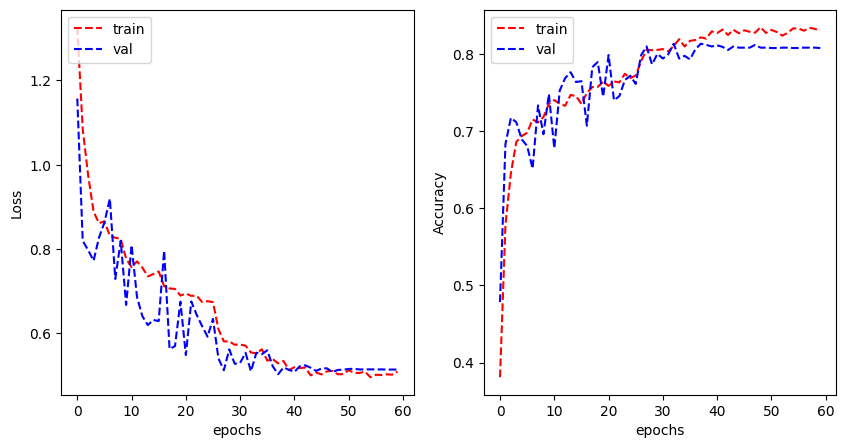

In [174]:
plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['categorical_accuracy'], history.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [175]:
test_data['cellType'] = test_data['cellType'].astype('str')
test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size_t = 1


test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_data,
        directory='./patch_images',
        x_col= "ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size_t,
        class_mode='categorical')

model.load_weights(checkpoint.filepath, by_name=True)

Found 1980 validated image filenames belonging to 4 classes.


In [176]:
print("Evaluate model on test data")
results = model.evaluate(test_generator)
print("test loss, test acc:", results)

# Generate a prediction using model.predict() 
# and calculate it's shape:
print("Generate a prediction")
prediction = model.predict(test_generator)
print("prediction shape:", prediction.shape)

Evaluate model on test data
1980/1980 [==============================] - 24s 12ms/step - loss: 0.5495 - categorical_accuracy: 0.7924 - mse: 0.0732
test loss, test acc: [0.5494740605354309, 0.7924242615699768, 0.0732230544090271]
Generate a prediction
1980/1980 [==============================] - 7s 4ms/step
prediction shape: (1980, 4)


In [177]:
extra_data = pd.read_csv('data_labels_extraData.csv')
print(extra_data.head())

   InstanceID  patientID  ImageName  isCancerous
0       12681         61  12681.png            0
1       12682         61  12682.png            0
2       12683         61  12683.png            0
3       12684         61  12684.png            0
4       12685         61  12685.png            0


In [190]:
extra_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last', rotation_range=45, width_shift_range=0.23,
                                   height_shift_range=0.23)

batch_size=32

extra_generator = extra_datagen.flow_from_dataframe(
        dataframe=extra_data,
        directory='./patch_images',
        x_col= "ImageName",
        y_col=None,
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode=None)


Found 10384 validated image filenames.


In [191]:
unlabeled_indices = extra_data.index.values
pseudo_labels = model.predict(extra_generator)
pseudo_labels = np.argmax(pseudo_labels, axis=1)
mapped_labels = pseudo_labels[unlabeled_indices]

325/325 [==============================] - 4s 12ms/step


In [192]:
extra_data['cellType'] = mapped_labels
combined_data = pd.concat([train_data, extra_data], axis=0)

In [200]:
combined_data['cellType'] = combined_data['cellType'].astype('str')
val_data['cellType'] = val_data['cellType'].astype('str')

combined_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last', rotation_range=30, width_shift_range=0.15,
                                   height_shift_range=0.15)
batch_size = 32

combined_generator = combined_datagen.flow_from_dataframe(
        dataframe=combined_data,
        directory='./patch_images',
        x_col= "ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./patch_images',
        x_col= "ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 16321 validated image filenames belonging to 4 classes.
Found 1979 validated image filenames belonging to 4 classes.


In [201]:
model.compile(optimizer=Adam(),
              loss=loss,
              metrics=['categorical_accuracy', 'mse'])

In [202]:
history_combined = model.fit(
    combined_generator,
    steps_per_epoch=len(combined_generator),
    epochs=50,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    class_weight=class_weights,
    shuffle=True,
    callbacks=[learn_control, checkpoint])

Epoch 1/50
511/511 [==============================] - ETA: 0s - loss: 0.6465 - categorical_accuracy: 0.7601 - mse: 0.0943
Epoch 1: val_categorical_accuracy did not improve from 0.81304
511/511 [==============================] - 16s 29ms/step - loss: 0.6465 - categorical_accuracy: 0.7601 - mse: 0.0943 - val_loss: 0.7063 - val_categorical_accuracy: 0.7696 - val_mse: 0.0838 - lr: 0.0010
Epoch 2/50
510/511 [============================>.] - ETA: 0s - loss: 0.6518 - categorical_accuracy: 0.7609 - mse: 0.0948
Epoch 2: val_categorical_accuracy did not improve from 0.81304
511/511 [==============================] - 13s 26ms/step - loss: 0.6519 - categorical_accuracy: 0.7608 - mse: 0.0948 - val_loss: 0.7440 - val_categorical_accuracy: 0.7529 - val_mse: 0.0869 - lr: 0.0010
Epoch 3/50
511/511 [==============================] - ETA: 0s - loss: 0.6532 - categorical_accuracy: 0.7569 - mse: 0.0952
Epoch 3: val_categorical_accuracy did not improve from 0.81304
511/511 [==============================] 

Epoch 22/50
510/511 [============================>.] - ETA: 0s - loss: 0.5813 - categorical_accuracy: 0.7823 - mse: 0.0862
Epoch 22: val_categorical_accuracy did not improve from 0.81304
511/511 [==============================] - 13s 26ms/step - loss: 0.5808 - categorical_accuracy: 0.7826 - mse: 0.0861 - val_loss: 0.6503 - val_categorical_accuracy: 0.7878 - val_mse: 0.0761 - lr: 2.0000e-04
Epoch 23/50
509/511 [============================>.] - ETA: 0s - loss: 0.5760 - categorical_accuracy: 0.7851 - mse: 0.0851
Epoch 23: val_categorical_accuracy did not improve from 0.81304
511/511 [==============================] - 14s 27ms/step - loss: 0.5755 - categorical_accuracy: 0.7854 - mse: 0.0851 - val_loss: 0.6953 - val_categorical_accuracy: 0.7827 - val_mse: 0.0776 - lr: 2.0000e-04
Epoch 24/50
511/511 [==============================] - ETA: 0s - loss: 0.5717 - categorical_accuracy: 0.7865 - mse: 0.0850
Epoch 24: val_categorical_accuracy did not improve from 0.81304
511/511 [==================

511/511 [==============================] - 14s 27ms/step - loss: 0.5557 - categorical_accuracy: 0.7902 - mse: 0.0833 - val_loss: 0.6481 - val_categorical_accuracy: 0.7898 - val_mse: 0.0756 - lr: 8.0000e-06
Epoch 43/50
511/511 [==============================] - ETA: 0s - loss: 0.5580 - categorical_accuracy: 0.7879 - mse: 0.0839
Epoch 43: val_categorical_accuracy did not improve from 0.81304
511/511 [==============================] - 13s 26ms/step - loss: 0.5580 - categorical_accuracy: 0.7879 - mse: 0.0839 - val_loss: 0.6487 - val_categorical_accuracy: 0.7903 - val_mse: 0.0760 - lr: 8.0000e-06
Epoch 44/50
510/511 [============================>.] - ETA: 0s - loss: 0.5535 - categorical_accuracy: 0.7905 - mse: 0.0826
Epoch 44: ReduceLROnPlateau reducing learning rate to 1.6000001778593287e-06.

Epoch 44: val_categorical_accuracy did not improve from 0.81304
511/511 [==============================] - 14s 27ms/step - loss: 0.5537 - categorical_accuracy: 0.7903 - mse: 0.0826 - val_loss: 0.6459

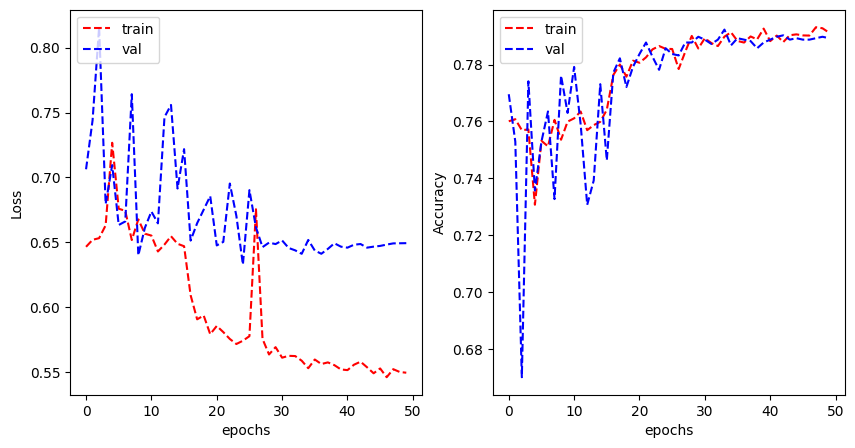

In [203]:
plot_learning_curve(history_combined.history['loss'], history_combined.history['val_loss'], 
                    history_combined.history['categorical_accuracy'], history_combined.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd

train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=42)

print("Train data : {}, Val data: {}, Test Data: {}".format(train_data.shape[0], val_data.shape[0],test_data.shape[0]))

In [ ]:
train_data['isCancerous'] = train_data['isCancerous'].astype('str')
val_data['isCancerous'] = val_data['isCancerous'].astype('str')

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last', rotation_range=45, width_shift_range=0.25,
                                   height_shift_range=0.25)
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./patch_images',
        x_col= "ImageName",
        y_col= "isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='binary')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./patch_images',
        x_col= "ImageName",
        y_col= "isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='binary')

In [ ]:
model = tf.keras.Sequential()
# Convolutional layers
model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(27, 27, 3)))
model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
          
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_uniform',))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_uniform',))
model.add(layers.MaxPooling2D((2, 2)))
          
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_uniform',))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_uniform',))
model.add(MaxPooling2D((2, 2)))

# Flatten layer
model.add(layers.Flatten())

# Dense layers
model.add(layers.Dense(512, activation='relu', kernel_initializer='he_uniform'))
model.add(layers.Dropout(rate=0.5))
model.add(layers.Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(layers.Dropout(rate=0.5))

# Output layer
model.add(layers.Dense(1, activation='sigmoid'))


In [ ]:
learn_control = ReduceLROnPlateau(monitor='val_accuracy', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-20)

filepath="weights_binary.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

model.compile(optimizer=Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
history_binary = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=40,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    shuffle=True,
    callbacks=[learn_control, checkpoint])

In [ ]:
plot_learning_curve(history_binary.history['loss'], history_binary.history['val_loss'], 
                    history_binary.history['accuracy'], history_binary.history['val_accuracy'], 
                    metric_name='Accuracy')

In [ ]:
test_data['isCancerous'] = test_data['isCancerous'].astype('str')
test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size_t = 1


test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_data,
        directory='./patch_images',
        x_col= "ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size_t,
        class_mode='binary')

model.load_weights(checkpoint.filepath, by_name=True)

In [ ]:
print("Evaluate model on test data")
results = model.evaluate(test_generator)
print("test loss, test acc:", results)

# Generate a prediction using model.predict() 
# and calculate it's shape:
print("Generate a prediction")
prediction = model.predict(test_generator)
print("prediction shape:", prediction.shape)